(content:references:spectra_part2)=
# Stellar Spectra Part 2: *The Cannon*

***Author: Marc Hon***

In [](content:references:spectra_part1), we introduced the idea of using well-characterized spectra as an empirical library as a reference to characterize the global stellar parameters of new stars. In this Section, we will examine an extension of this idea in the context of supervised learning using large datasets of labelled spectra with varying signal-to-noise ratios.

Introduced by [Ness et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...808...16N/abstract), *The Cannon* is a simple yet effective data-driven model that learns how stellar spectra vary as a function of stellar labels, including global stellar parameters like effective temperature $T_{\mathrm{eff}}$, surface gravity $\log (g)$, and metallicity [Fe/H]. 

In the following, we will explore the framework of *The Cannon* model based on the code and tutorial provided [here](https://annayqho.github.io/TheCannon/). 

```{note}
The name of *The Cannon* is inspired by the astronomer [Annie Jump Cannon](https://en.wikipedia.org/wiki/Annie_Jump_Cannon), a pioneer of stellar classifications based on stars' spectral types.
```

## Spectra Pre-processing

In the previous section, we utilized a library in which we had high-resolution spectra that were already pre-processed to be science-ready. This level of data readiness is the exception rather than the norm. In practice, spectral data acquired from large stellar surveys span a wide range of signal-to-noise levels and are often released in various stages of reduction, all of which require additional processing before they can be reliably used for scientific analysis. 


Let's load in a dataset from The Apache Point Observatory Galactic Evolution Experiment (**APOGEE**) Data Release 10, comprising high resolution (R $\sim$22,500), high signal to noise (S/N $\sim$100), spectra of stars in the Milky Way in the H-band (15200–16900 Å).

In [1]:
import os
import corner
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from copy import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'data'

plt.style.use('science')

fs = 18

First, we load in the IDs, wavelengths, flux, and per-pixel-uncertainty (**inverse variance**) of the dataset.

In [2]:
from TheCannon import apogee

spectra_ID, wave, flux, inverse_var = apogee.load_spectra(str(data_folder_path) + "/cannon_data/example_DR10/Data")

Loading spectra from directory /home/marc/jupyter-book/ml_astro/chapter2/data/cannon_data/example_DR10/Data
Spectra loaded


Let's examine how some of these spectra appear:

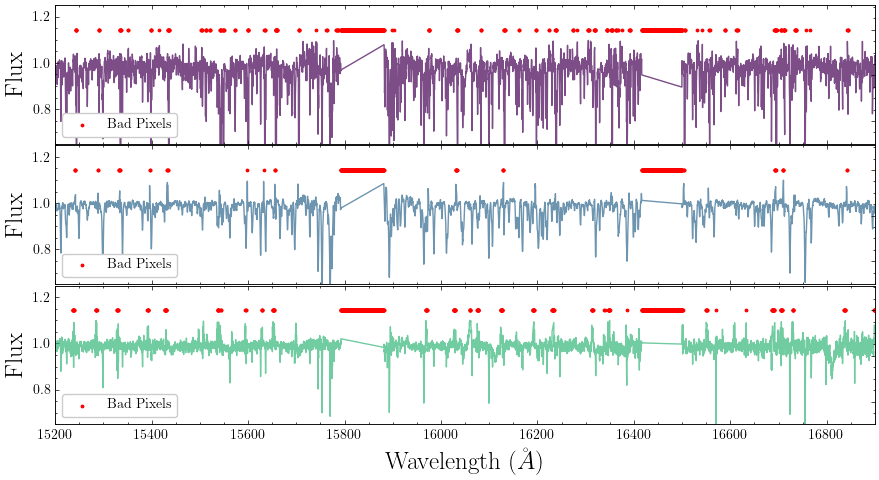

In [3]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
idxes = [2, 22, 222]
cmap = plt.cm.viridis 
norm = colors.Normalize(vmin=0, vmax=len(idxes))

for i, (idx,ax) in enumerate(zip(idxes,axlist)):
    plot_flux = flux[idx]
    ax.plot(wave[plot_flux > 0], plot_flux[plot_flux > 0], color=cmap(norm(i)), alpha=0.7)
    ax.set_xlim(15200, 16900)
    ax.set_ylim(0.65, 1.25)
    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
    
    bad_pixels = np.abs((inverse_var[idx] > 0))
    axtwin = ax.twinx()
    axtwin.scatter(wave[bad_pixels == 0], bad_pixels[bad_pixels == 0], c='r', s=3,
                  label = 'Bad Pixels')
    axtwin.set_ylim(-5, 1.08)
    axtwin.set_yticklabels([])
    axtwin.legend(frameon=True,framealpha=1)
plt.tight_layout(h_pad=0.1); plt.show()

There are three main features to observe:

- The spectra have spikes, indicative of bad data points or pixels. These are indicated with a zero inverse variance, so an infinitely large uncertainty.
- The baseline, or **continuum**, of the spectra are already close to 1, but may still show some deviation
- The presence of discontinuities in the spectra causd by the gaps between the instrument’s three detectors

Next, we load in the **labels** of the dataset. These are the effective temperature $T_{\mathrm{eff}}$, surface gravity $\log (g)$, and metallicity [Fe/H].

In [4]:
labels = apogee.load_labels(str(data_folder_path) + "/cannon_data/example_DR10/reference_labels.csv")

Loading reference labels from file /home/marc/jupyter-book/ml_astro/chapter2/data/cannon_data/example_DR10/reference_labels.csv


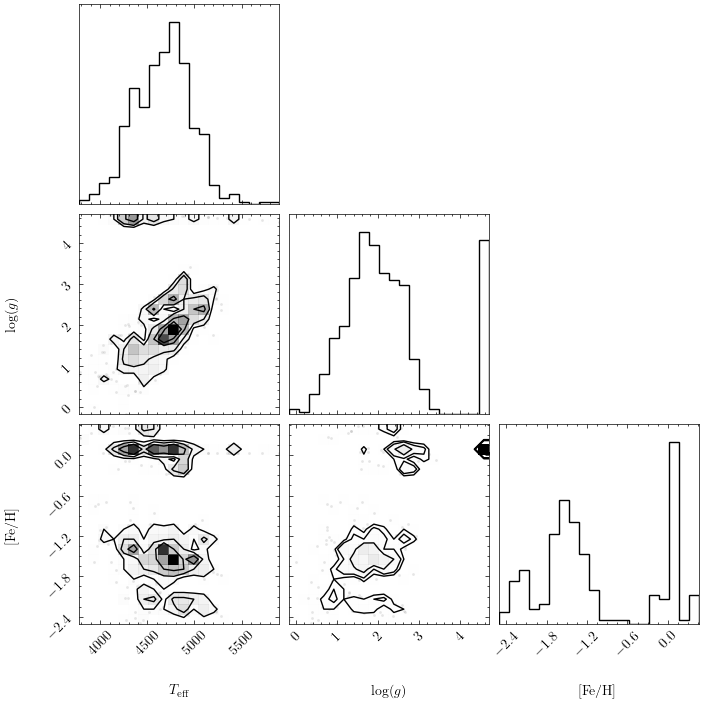

In [5]:
label_str = ['$T_{\mathrm{eff}}$', '$\log (g)$', '[Fe/H]']
fig = corner.corner(labels, labels = label_str)
plt.show()

Before we continue, let's define a hold-out validation set comprising 10% of the spectra into a `Dataset` instance.

In [6]:
from TheCannon import dataset

# Shuffle and split star indices
np.random.seed(42)  # for reproducibility
np.random.shuffle(np.arange(len(spectra_ID)))

# 90% for training, 10% for validation
split_idx = int(0.8 * len(spectra_ID))

train_ID, train_flux, train_ivar, train_labels = spectra_ID[:split_idx], flux[:split_idx], inverse_var[:split_idx], labels[:split_idx]
val_ID, val_flux, val_ivar, val_labels = spectra_ID[split_idx:], flux[split_idx:], inverse_var[split_idx:], labels[split_idx:]

ds = dataset.Dataset(wave, train_ID, train_flux, train_ivar, train_labels,
                     val_ID, val_flux, val_ivar)
ds.set_label_names(['T_{eff}', '\log g', '[Fe/H]'])

Loading dataset
This may take a while...


## Continuum Normalization


### Pseudo-Normalization

As pre-processing, the baseline flux needs to be normalized to unity, such that line depths from absorption features can be reliably measured.

To begin, we determine a preliminary pseudo-continuum by fitting the 90th percentile of a running quantile of length 50 Å across each spectra.

In [7]:
from TheCannon.normalization import _find_cont_running_quantile

ds.ranges = [[371,3192], [3697,5997], [6461,8255]] # define range of spectral indices containing flux

idx = 0 # index in training set

prelim_cont = []

for r in ds.ranges: # For each chunk containing flux, pseudo-normalize
    prelim_cont.append(_find_cont_running_quantile(wave[r[0]: r[1]],
                                              train_flux[idx, r[0]: r[1]][None, :],
                                              train_ivar[idx, r[0]: r[1]][None, :],
                                              q=0.9, delta_lambda=50))

[15178.40021992 15178.60991872 15178.81962041 ... 15780.98111083
 15781.19913465 15781.41716148]
[15892.12601166 15892.34557102 15892.5651334  ... 16404.53785323
 16404.76449186 16404.99113362]
[16510.71952845 16510.94763404 16511.17574279 ... 16924.35007496
 16924.58389511 16924.8177185 ]


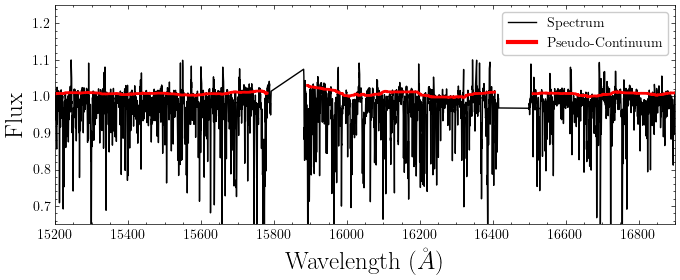

In [9]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_subplot(111)
ax1.plot(wave[train_flux[idx] > 0], train_flux[idx][train_flux[idx] > 0], c='k', label='Spectrum')

for i, r in enumerate(ds.ranges):
    print(wave[r[0]: r[1]])
    ax1.plot(wave[r[0]: r[1]], prelim_cont[i].squeeze(), lw=2, c='r')
ax1.plot([], [], lw=3, c='r', label='Pseudo-Continuum')
    
ax1.set_xlim(15200, 16900)
ax1.set_ylim(0.65, 1.25)
ax1.set_ylabel('Flux', fontsize=fs)
ax1.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
ax1.legend(framealpha=1, frameon=True)
plt.tight_layout(h_pad=0.1); plt.show()

We do this systematically across the whole dataset to get pseudo-normalized spectra.

In [ ]:
ds.ranges = [[371,3192], [3697,5997], [6461,8255]] # define range of spectral indices containing flux
pseudo_tr_flux, pseudo_tr_ivar = ds.continuum_normalize_training_q(q=0.90, delta_lambda=50,
                                                                  verbose=False)

### Identifying Continuum Pixels Across the Dataset

The next step is to identify wavelengths where:

- The median flux across stars is close to unity,

- The variance of the flux across stars is low (indicating stability),

- The inverse variances aren't trivially small or constant (i.e., uninformative).

The selection is adjusted iteratively until a specified target fraction of the spectrum is labeled as continuum. In this example, it is set to 7\%. This set of continuum pixels is **shared across the whole dataset**.

```{important}
This continuum is additionally shared across training and test sets.
```

In [43]:
contmask = ds.make_contmask(pseudo_tr_flux, pseudo_tr_ivar, frac=0.07)

Finding continuum pixels...
taking spectra in 3 regions
Target frac: 0.07
198 out of 2821 pixels identified as continuum
Cuts: f_cut 0.0059000000000000025, sig_cut 0.0059000000000000025
Target frac: 0.07
167 out of 2300 pixels identified as continuum
Cuts: f_cut 0.006800000000000005, sig_cut 0.006800000000000005
Target frac: 0.07
127 out of 1794 pixels identified as continuum
Cuts: f_cut 0.007100000000000006, sig_cut 0.007100000000000006
492 pixels returned as continuum


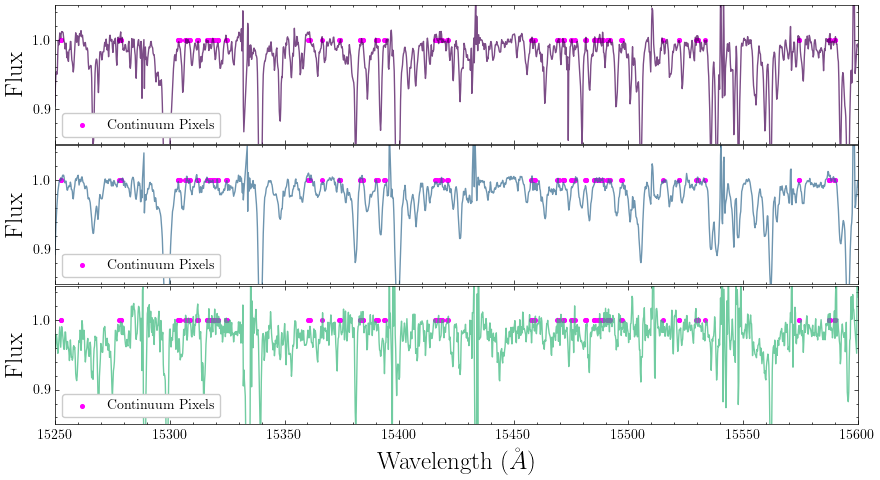

In [63]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
idxes = [12, 22, 322]
cmap = plt.cm.viridis 
norm = colors.Normalize(vmin=0, vmax=len(idxes))

for i, (idx,ax) in enumerate(zip(idxes,axlist)):
    plot_flux = pseudo_tr_flux[idx]
    ax.plot(wave[plot_flux > 0], plot_flux[plot_flux > 0], color=cmap(norm(i)), alpha=0.7)
    ax.set_xlim(15250, 15600)
    ax.set_ylim(0.85, 1.05)
    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
    ax.scatter(wave[plot_flux > 0], contmask[plot_flux > 0], c='magenta', s=7, label='Continuum Pixels')
    ax.legend(frameon=True,framealpha=1, loc='lower left')    
plt.tight_layout(h_pad=0.1); plt.show()

We see that the continuum selection highlights pixels (wavelength channels) that are consistently near to unity across training spectra. The next step is to fit these pixels with a low-order Chebyshev (or sinusoidal) polynomial across wavelengths, which determines the continuum.

In [76]:
ds.set_continuum(contmask)
cont = ds.fit_continuum(2, "chebyshev")  # tuple of (train_cont, test_cont)

Fitting Continuum...
Fitting Continuum in 3 Regions...


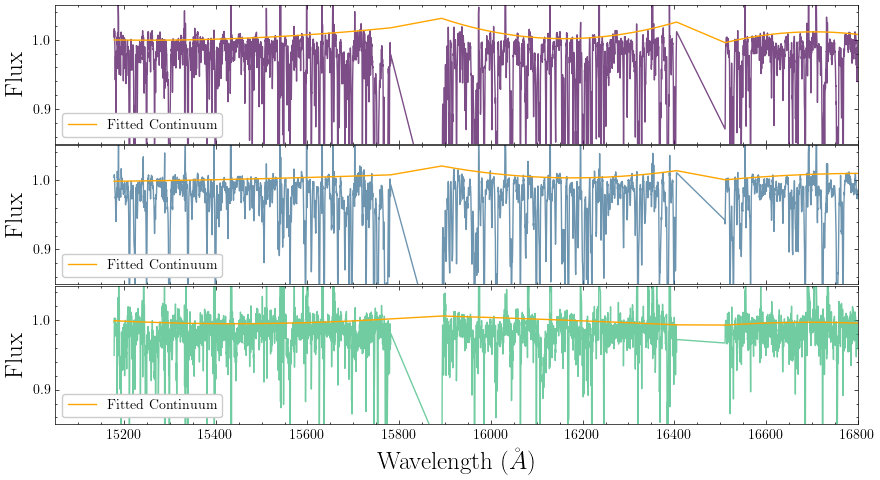

In [81]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
idxes = [12, 22, 322]
cmap = plt.cm.viridis 
norm = colors.Normalize(vmin=0, vmax=len(idxes))

for i, (idx,ax) in enumerate(zip(idxes,axlist)):
    plot_flux = pseudo_tr_flux[idx]
    plot_cont = cont[0][idx]
    ax.plot(wave[plot_flux > 0], plot_flux[plot_flux > 0], color=cmap(norm(i)), alpha=0.7)
    ax.set_xlim(15050, 16800)
    ax.set_ylim(0.85, 1.05)
    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
    ax.plot(wave[plot_flux > 0], plot_cont[plot_flux > 0], c='orange', label='Fitted Continuum')
    ax.legend(frameon=True,framealpha=1, loc='lower left')    
plt.tight_layout(h_pad=0.1); plt.show()

The final step is to normalize the spectra with the fitted continuum. For this example, many raw spectra have continuum already close to unity so their normalization may appear subtle by eye.

In [78]:
norm_train_flux, norm_train_ivar, norm_test_flux, norm_test_ivar = ds.continuum_normalize(cont)

taking spectra in 3 regions


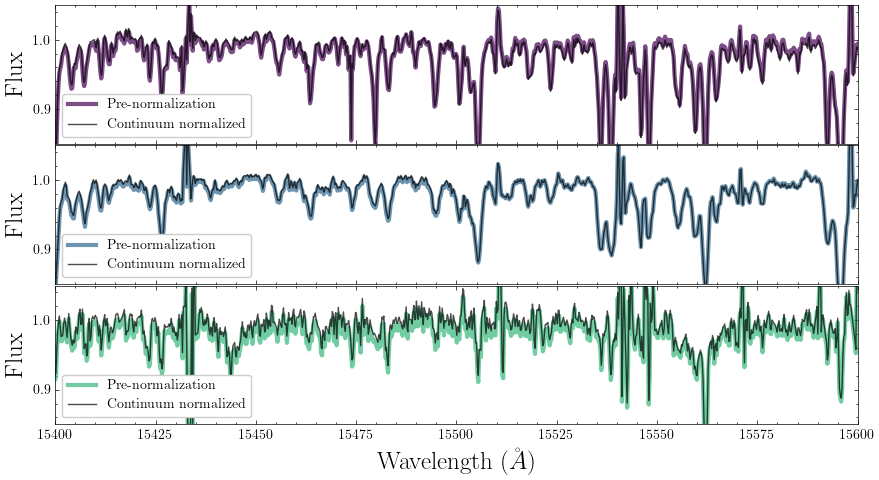

In [85]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
idxes = [12, 22, 322]
cmap = plt.cm.viridis 
norm = colors.Normalize(vmin=0, vmax=len(idxes))

for i, (idx,ax) in enumerate(zip(idxes,axlist)):
    plot_flux = pseudo_tr_flux[idx]
    plot_norm_flux = norm_train_flux[idx]
    ax.plot(wave[plot_flux > 0], plot_flux[plot_flux > 0], color=cmap(norm(i)), alpha=0.7, lw=3,
           label='Pre-normalization')
    ax.plot(wave[plot_flux > 0], plot_norm_flux[plot_flux > 0], color='k', alpha=0.7,
           label='Continuum normalized')
    ax.set_xlim(15400, 15600)
    ax.set_ylim(0.85, 1.05)
    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
    ax.legend(frameon=True,framealpha=1, loc='lower left')    
plt.tight_layout(h_pad=0.1); plt.show()

```{important}
Continuum normalization is a critical preprocessing step in stellar spectroscopic analysis. Its accurate normalization ensures that the intrinsic shape of the stellar continuum is removed, which allows spectral line depths and profiles to be compared meaningfully across different stars. Since *The Cannon* models the flux at each wavelength as a function of stellar labels, any residual continuum shape or miscalibration can introduce systematic errors that bias the learned model coefficients.
```

With data adequately normalized, we are now prepared to train *The Cannon* to predict stellar labels from spectra!

##  The Cannon Model

At each wavelength pixel $ \lambda $, the normalized flux $ f_\lambda $ is modeled as a function of stellar labels using a linear (or polynomial) expansion:

$$
f_\lambda = \theta_{\lambda,0} + \sum_i \theta_{\lambda,i} \cdot \ell_i + \sum_{i \le j} \theta_{\lambda,ij} \cdot \ell_i \cdot \ell_j + \epsilon_\lambda
$$

Where:

- $ \ell_i $: Stellar labels (e.g., $ T_{\mathrm{eff}}, \log g, [\mathrm{Fe/H}] $)
- $ \theta_{\lambda,*} $: Model coefficients (also called **leading coefficients**)
- $ \epsilon_\lambda $: Residual noise term at wavelength $ \lambda $

###  Types of Coefficients

- $ \theta_{\lambda,0} $: **Intercept term** — the model prediction when all labels are zero
- $ \theta_{\lambda,i} $: **Linear terms** — describe how flux changes linearly with each label
- $ \theta_{\lambda,ij} $: **Quadratic and cross terms** — capture label interactions (included for second-order models)

For our example in which we predict $ T_{\mathrm{eff}}, \log g, [\mathrm{Fe/H}] $, the label vector $\ell_k$ is thus 10-dimensional:


$$
[1, T_{\mathrm{eff}}, \log g, [\mathrm{Fe/H}], T_{\mathrm{eff}}\cdot T_{\mathrm{eff}}, T_{\mathrm{eff}}\cdot \log g, T_{\mathrm{eff}} \cdot [\mathrm{Fe/H}], \log g\cdot \log g,  \log g \cdot [\mathrm{Fe/H}], [\mathrm{Fe/H}]\cdot [\mathrm{Fe/H}]]
$$

```{note}
The adopted implementation of **The Cannon** implicitly assumes coefficients up to quadratic terms.
```
The following performs a fit to the training set:

In [86]:
from TheCannon import model
md = model.CannonModel(2, False)
md.fit(ds)

Done training model. 



## Interpreting *The Cannon*'s Coefficients 

A strength of *The Cannon* lies in its interpretability. In its quadratic model, the flux at each wavelength pixel $ \lambda $ is expressed as a polynomial function of the stellar labels. When the label offsets $ \ell_k $ are defined relative to their mean values (i.e., centered), the model coefficients define a local **Taylor-like expansion** of the spectrum around the mean stellar labels:

- **Zeroth-order coefficient $ \theta_{\lambda,0} $**  
  Represents the **baseline spectrum** evaluated at the mean label values. In other words, the average spectrum across the training set.

- **First-order coefficients $ \theta_{\lambda,k} $**  
  These correspond to the **partial derivatives** of the flux with respect to each stellar label:
  
  $$
  \theta_{\lambda,k} \approx \left. \frac{\partial f_\lambda}{\partial \ell_k} \right|_{\text{mean labels}}
  $$
 
In other words, they capture the **local sensitivity** of the spectrum at wavelength $ \lambda $ to variations in label $ \ell_k $, evaluated at the reference (mean) stellar parameters.

- **Second-order coefficients $ \theta_{\lambda,kk'} $**  
  These describe the **curvature** of the label–flux relationship:
  
  $$
  \theta_{\lambda,kk'} \approx \left. \frac{\partial^2 f_\lambda}{\partial \ell_k \, \partial \ell_{k'}} \right|_{\text{mean labels}}
  $$
  
They represent the average **second derivative** of the flux with respect to label pairs $ (\ell_k, \ell_{k'}) $, capturing both nonlinear effects and interactions between stellar parameters.

Let's examine the first order coefficients of the model.

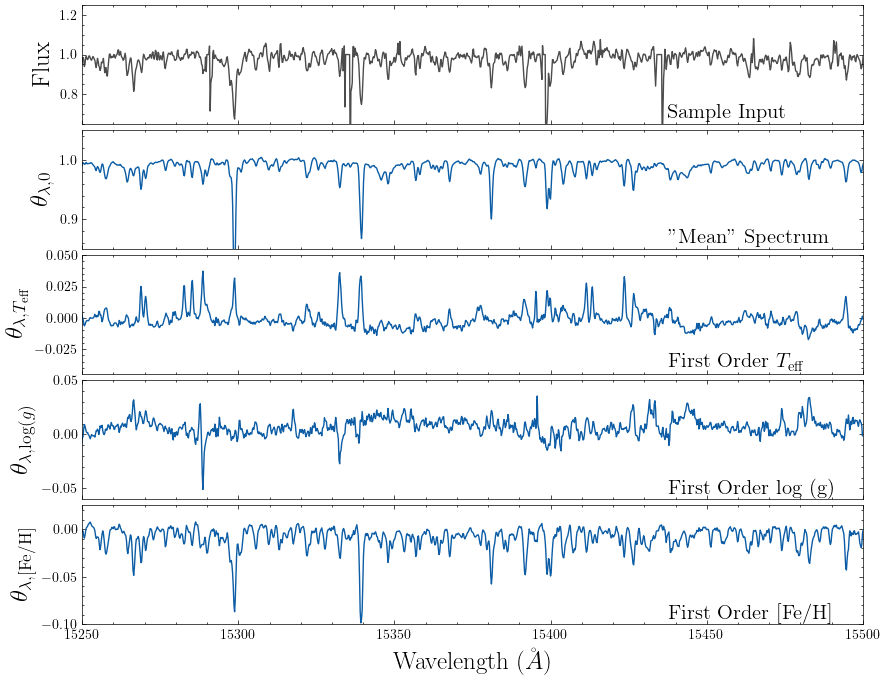

In [132]:
fig = plt.figure(figsize=(9, 7))
ax1, ax2, ax3, ax4, ax5 = fig.add_subplot(511), fig.add_subplot(512), fig.add_subplot(513), fig.add_subplot(514), fig.add_subplot(515)
axlist = [ax1, ax2, ax3, ax4, ax5]
ylabels = ['Flux', '$\\theta_{\\lambda, 0}$', '$\\theta_{\\lambda, T_{\\mathrm{eff}}}$',
          '$\\theta_{\\lambda, \\log (g)}$', '$\\theta_{\\lambda, \\mathrm{[Fe/H]}}$']
texts = ['Sample Input', '"Mean" Spectrum', 'First Order $T_{\\mathrm{eff}}$',
        'First Order $\\log$ (g)', 'First Order [Fe/H]']
idxes = 2
cmap = plt.cm.viridis 

plot_flux = norm_train_flux[idxes]
plot_cond = (plot_flux > 0) 

ax1.plot(wave[plot_cond], plot_flux[plot_cond], color='k', alpha=0.7, label='Example Input Spectrum')
ax1.set_ylim(0.65, 1.25)
ax2.set_ylim(0.85, 1.05); ax3.set_ylim(-0.045, 0.05); ax4.set_ylim(-0.06, 0.05); ax5.set_ylim(-0.1, 0.025)
ax2.plot(wave[md.coeffs.T[0] > 0], md.coeffs.T[0][md.coeffs.T[0] > 0])


for i, ax in enumerate(axlist):
    ax.set_xlim(15250, 15500)
    if i > 1:
        axlist[i].plot(wave[plot_cond], md.coeffs.T[i-1][plot_cond])
    if i != len(axlist) - 1:
        axlist[i].set_xticklabels([])
    else:
        axlist[i].set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    ax.set_ylabel(ylabels[i], fontsize=fs)
    ax.text(x=0.75, y=0.05, s=texts[i], transform=ax.transAxes, fontsize=fs-3)
plt.tight_layout(h_pad=0.1); plt.show()

In the above, which can quickly identify spectral features (or atomic lines) across the dataset that contribute significantly to the a particular global stellar parameter. More broadly, we can see that the [Fe/H] label is
dominant in the contribution level and that there are far fewer regions of $\log$ (g) sensitivity as compared to the other parameters. There is also significant covariance between the labels (particularly $T_{\mathrm{eff}}$) and [Fe/H].

## Predictions on validation set
Let's examine the accuracy of the trained model on the hold-out validation set.

At test time, The Cannon infers the stellar labels $ \boldsymbol{\ell} $ of a new spectrum by minimizing the following chi-squared objective function:

$$
\chi^2(\boldsymbol{\ell}) = \sum_{\lambda} \frac{\left[f_\lambda^{\mathrm{obs}} - \hat{f}_\lambda(\boldsymbol{\ell})\right]^2 }{\sigma_\lambda^2 + s_\lambda^2}
$$

Where:

- $ f_\lambda^{\mathrm{obs}} $ is the observed flux at wavelength $ \lambda $,
- $ \hat{f}_\lambda(\boldsymbol{\ell}) $ is the model-predicted flux given the label vector $ \boldsymbol{\ell} $,
- $ \mathrm{ivar}_\lambda = 1/\sigma_\lambda^2 $ is the inverse variance of the observed flux,
- $ s_\lambda^2 $ is the model's intrinsic scatter at each wavelength,
- $ \hat{f}_\lambda(\boldsymbol{\ell}) = \boldsymbol{\theta}_\lambda^T \cdot \ell_k $, where:
  - $ \boldsymbol{\theta}_\lambda $ is the vector of model coefficients at wavelength $ \lambda $,
  - $ \phi(\boldsymbol{\ell}) $ is the label vector (including linear, quadratic, and interaction terms).

The goal is to find the label vector $ \boldsymbol{\ell}_{\mathrm{pred}}$ that minimizes this chi-squared across all wavelength pixels.

In [140]:
starting_guess = np.mean(ds.tr_label,axis=0)-md.pivots
errs, chisq = md.infer_labels(ds, starting_guess)

Inferring Labels


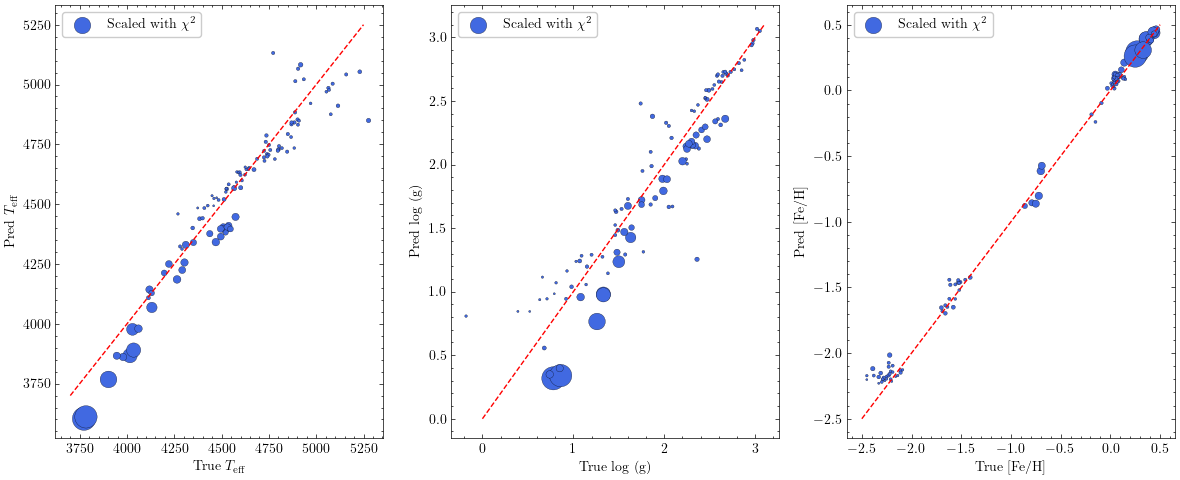

In [153]:
fig = plt.figure(figsize=(12,5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
axlist = [ax1, ax2, ax3]
bounds = [[3700, 5250], [0, 3.1], [-2.5, 0.5]]
plot_labels = ['$T_{\mathrm{eff}} (K)$', '$\log$ (g) (dex)', '[Fe/H] (dex)']

for i, ax in enumerate(axlist):   
    ax.scatter(val_labels[:,i], ds.test_label_vals[:,i], s=chisq/1000., c='royalblue', lw=0.2, edgecolor='k',
              label='Scaled with $\\chi^2$')
    ax.plot(bounds[i], bounds[i], c='red', ls='--')
    ax.legend(framealpha=1, frameon=True)
    ax.set_ylabel(f'Pred {plot_labels[i]}')
    ax.set_xlabel(f'True {plot_labels[i]}')
plt.tight_layout(h_pad=1)

The model performs reasonably well, but we see that it begins to falter in accuracy for cool, low $\log$ (g) stars -- namely evolved giant stars. It is, however, still able to predict the [Fe/H] of such stars reliably. 

### Predictions as a generative model

Recall that *The Cannon* is a **generative model**. This means that given $ \boldsymbol{\ell}_{\mathrm{pred}}$, we  have access to the corresponding model predicted flux $ \hat{f}_\lambda(\boldsymbol{\ell}_{\mathrm{pred}})$. Below we show  $ \hat{f}_\lambda(\boldsymbol{\ell}_{\mathrm{pred}})$ for three scenarios: the best prediction, the worse prediction, and a typical prediction in the validation set.

In [156]:
md.infer_spectra(ds)
pred_flux = md.model_spectra

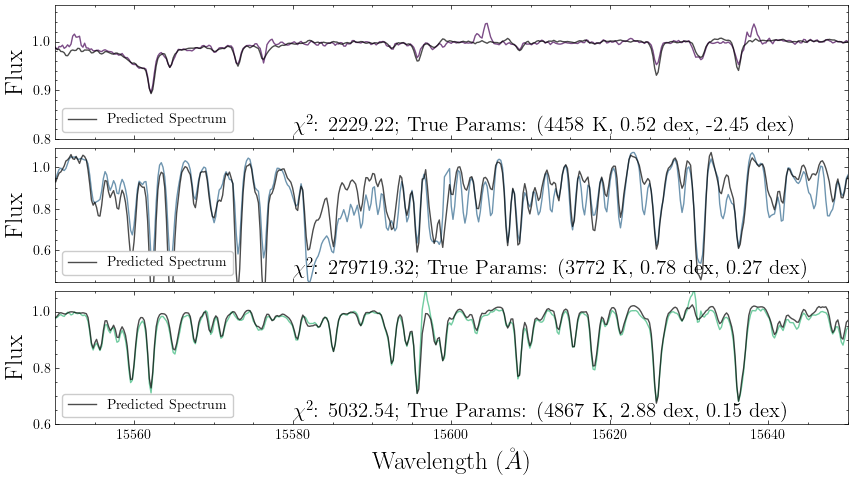

In [194]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
idxes = [np.argmin(chisq), np.argmax(chisq), int(np.median(np.arange(len(chisq))[np.argsort(chisq)] ))]
cmap = plt.cm.viridis 
norm = colors.Normalize(vmin=0, vmax=len(idxes))
ax1.set_ylim(0.8, 1.075)
ax2.set_ylim(0.45, 1.095)
ax3.set_ylim(0.6, 1.075)

for i, (idx,ax) in enumerate(zip(idxes,axlist)):
    plot_flux = norm_test_flux[idx]
    cond = (plot_flux > 0) & (norm_test_ivar[idx] > 0)
    ax.plot(wave[cond], plot_flux[cond], color=cmap(norm(i)), alpha=0.7)
    ax.plot(wave[cond], pred_flux[idx][cond], color='k', alpha=0.7, label='Predicted Spectrum')

    ax.set_xlim(15550, 15650)

    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
    ax.text(x=0.3, y=0.06, s=f'$\\chi^2$: {chisq[idx]:.2f}; True Params: ({val_labels[idx,0]:.0f} K, {val_labels[idx,1]:.2f} dex, {val_labels[idx,2]:.2f} dex)', transform=ax.transAxes, fontsize=fs-3)
    ax.legend(loc='lower left', frameon=1, framealpha=1)
plt.tight_layout(h_pad=0.1); plt.show()

We see that the best prediction lies with a fairly featureless spectrum, typical of metal-poor stars. On the other hand, the worst prediction lies with a spectrum dense with lines, in this case belonging to a metal-rich, cool giant star. This is a combination of the following:

- Many more atoms reside in low-excitation levels in cooler stars, which enables transitions with low excitation potentials
- Molecules that are otherwise thermally dissociated can survive in cooler atmospheres, and these may show dense forests of absorption features due to rotational-vibrational transitions

`````{admonition} Exercise
1. Repeat the fitting to a model of *The Cannon*, but vary the following:

- Parameters `q` and `delta_lambda` in `ds.continuum_normalize_training_q`
- `frac` in `ds.make_contmask`, which modifies the fraction of pixels defined as continuum
- The order of the polynomial in `ds.fit_continuum` and modify the function from `chebyshev` to `sinusoid`

These modify the normalization properties of the continuum. Do you obtain the same predictive performance upon changing these parameters?

2. Train a model of *The Cannon* on the Keck/HIRES spectra from [](content:references:spectra_part1), which is already normalized. Compare and contrast *The Cannon* with the empirical library matching method (Spec-Match), with particular attention to stars at the edges of the training label space. How do the methods differ in behavior and reliability for outlier stars?. 

3. Continuing from #2, add varying levels of Gaussian noise to the normalized Keck/HIRES spectra (e.g., SNR = 100, 50, 20, 10). The SNR can be taken as the inverse of the standard deviation of the continuum regions, assuming that the continuum is normalized to a value of 1. Retrain or reuse The Cannon model where appropriate, and re-run the empirical library matching. Evaluate how label inference and spectral reconstruction degrade as SNR decreases. Which method remains more stable, and why?
`````